In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import pickle

In [2]:
# Set default sizes for figures.
plt.style.use("default") # style matplotlib
plt.rc("axes", labelsize = 15) # fontsize of the x and y labels
plt.rc("axes", titlesize = 15) # fontsize of the axes title
plt.rc("xtick", labelsize = 15) # fontsize of the tick labels
plt.rc("ytick", labelsize = 15) # fontsize of the tick labels
plt.rc("legend", fontsize = 15) # legend fontsize

## Configuration

In [3]:
# Define the project analysis to visualize.
ANALYSIS_NAME = "Analysis 2022 Same Time Length" 
PROJECT_ROOT = f"./RESULTS/{ANALYSIS_NAME}"

In [4]:
# Load corresponding simulations (hyper-parameter tuning + forecasting) for each country.
COUNTRIES = ["Yemen", "Syria", "Burkina Faso", "Nigeria", "Mali", "Cameroon"] 
COLORS = {country: sns.color_palette("tab10")[i] for i, country in enumerate(COUNTRIES)}

In [5]:
for country in COUNTRIES:
    print(country)
    # Load forecasting results for each split.
    xls = pd.ExcelFile(f"{PROJECT_ROOT}/{country}/standard/out_test/forecast.xlsx")

    for i, split in enumerate(xls.sheet_names[1:]):
        forecast_split = pd.read_excel(xls, split, index_col = 0, header = [0, 1, 2])
        print(f"{split}: {forecast_split.index[0].date()} - {forecast_split.index[-1].date()}")

Yemen
Split 1: 2021-10-01 - 2021-10-30
Split 2: 2021-11-01 - 2021-11-30
Split 3: 2021-12-01 - 2021-12-30
Split 4: 2022-01-01 - 2022-01-30
Split 5: 2022-02-01 - 2022-03-02
Syria
Split 1: 2021-10-01 - 2021-10-30
Split 2: 2021-11-01 - 2021-11-30
Split 3: 2021-12-01 - 2021-12-30
Split 4: 2022-01-01 - 2022-01-30
Split 5: 2022-02-01 - 2022-03-02
Burkina Faso
Split 1: 2021-10-01 - 2021-10-30
Split 2: 2021-11-01 - 2021-11-30
Split 3: 2021-12-01 - 2021-12-30
Split 4: 2022-01-01 - 2022-01-30
Split 5: 2022-02-01 - 2022-03-02
Nigeria
Split 1: 2021-10-01 - 2021-10-30
Split 2: 2021-11-01 - 2021-11-30
Split 3: 2021-12-01 - 2021-12-30
Split 4: 2022-01-01 - 2022-01-30
Split 5: 2022-02-01 - 2022-03-02
Mali
Split 1: 2021-10-01 - 2021-10-30
Split 2: 2021-11-01 - 2021-11-30
Split 3: 2021-12-01 - 2021-12-30
Split 4: 2022-01-01 - 2022-01-30
Split 5: 2022-02-01 - 2022-03-02
Cameroon
Split 1: 2021-10-01 - 2021-10-30
Split 2: 2021-11-01 - 2021-11-30
Split 3: 2021-12-01 - 2021-12-30
Split 4: 2022-01-01 - 2022-01

## Figures

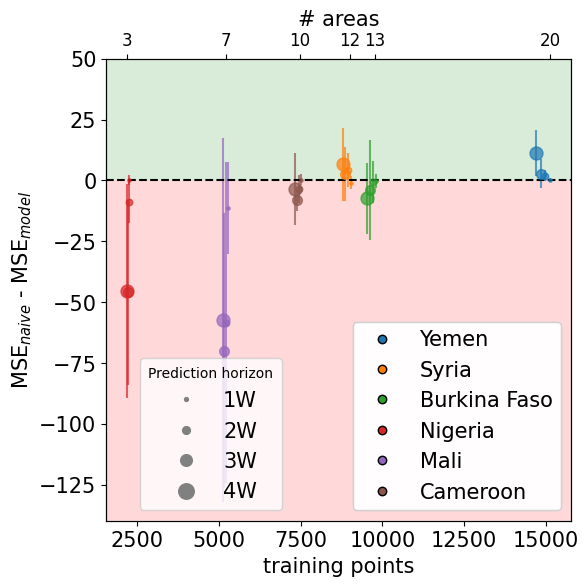

In [6]:
fig, axs = plt.subplots(figsize = (6, 6))

n_provinces = []
for i, country in enumerate(COUNTRIES):
    # Load training shapes.
    training_shape = pd.read_csv(f"{PROJECT_ROOT}/{country}/standard/out_test/training_shapes.csv", header = [0,1], index_col = 0)
    training_shape = training_shape.xs("training points", axis = 1, level = 1, drop_level = False)
        
    # Load mse loss based on prediction horizons.
    loss_h = pd.read_csv(f"{PROJECT_ROOT}/{country}/standard/out_test/loss_h.csv", index_col = [0, 1], header = [0, 1]).droplevel(0, axis = 0)
    
    results = loss_h.stack(["Split"])
    # For each split get difference between 'mse_naive' and 'mse_model'.
    results["diff"] =  results["mse_naive"] - results["mse_model"]
    results = results.unstack().reorder_levels(["Split", "Type"], axis = 1).xs("diff", axis = 1, level = 1, drop_level = False)
    # Concatenate loss and training shape information.
    results = pd.concat([results, training_shape], axis = 1).sort_index(axis = 1)
    # Take the mean across all the splits.
    results_mean = results.groupby(axis = 1, level = 1).mean()
    results_std = results.groupby(axis = 1, level = 1).std()
    # Select some prediction horizon for visualiztion.
    results_mean = results_mean.loc[[7, 14, 21, 28]]
    results_std = results_std.loc[[7, 14, 21, 28]]
    
    # Provinces.
    with open(f"{PROJECT_ROOT}/{country}/standard/provinces_considered", "rb") as fp:
        provinces = pickle.load(fp)
    n_provinces.append((len(provinces[country]), training_shape.mean().mean()))

    for j in range(len(results_mean)):
        axs.errorbar(results_mean.iloc[j]["training points"], results_mean.iloc[j]["diff"],
                     yerr = results_std.iloc[j]["diff"], marker = "o", linestyle = "none", 
                     color = COLORS[country], markersize = results_mean.index[j]/3, 
                     alpha = 0.7)

# Add 0 line.
axs.axhline(y = 0, color = "black", linestyle = "--")

ax2 = axs.twiny()
ax2.plot([x[1] for x in n_provinces], np.ones(len(n_provinces)), alpha = 0) # Create a dummy plot
xticks = ax2.get_xticks()
ax2.set_xticks([x[1] for x in n_provinces])
ax2.set_xticklabels([str(x[0]) for x in n_provinces], fontdict = {'fontsize': 12})
ax2.set_xlabel("# areas")
 
# Legend.
h = [plt.plot([],[], color = COLORS[country], marker = "o", ls = "", markeredgewidth = 1, 
              markeredgecolor = "black")[0] for i, country in enumerate(COUNTRIES)]
h = plt.legend(handles = h, labels = COUNTRIES, loc = "lower right")

h1 = [plt.plot([],[], color = "gray", marker = "o", ms = i, ls = "")[0] for i in results_mean.index.values/2.5]
axs.legend(handles = h1, labels = ["1W", "2W", "3W", "4W"], loc = "upper right", bbox_to_anchor = (0.4,0.375), 
           title = "Prediction horizon")

plt.gca().add_artist(h)

axs.set_xlabel("training points")
axs.set_ylabel("MSE$_{naive}$ - MSE$_{model}$")

a = (axs.get_xlim()[0], axs.get_xlim()[1])
b = (axs.get_ylim()[0], 50)

axs.fill_between(np.arange(a[0], a[1]), 0, b[1], facecolor = "green", alpha = 0.15)
axs.fill_between(np.arange(a[0], a[1]), 0, b[0], facecolor = "red", alpha = 0.15)

axs.set_xlim(a)
axs.set_ylim((b[0], 50))

fig.savefig(f"./IMAGES/{ANALYSIS_NAME}/all_countries.png" , bbox_inches = "tight", dpi = 300)

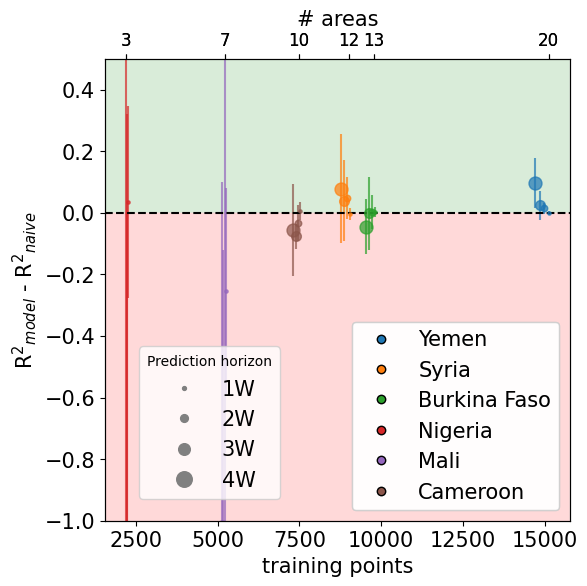

In [7]:
fig, axs = plt.subplots(figsize = (6, 6))

for i, country in enumerate(COUNTRIES):
    # Load training shapes.
    training_shape = pd.read_csv(f"{PROJECT_ROOT}/{country}/standard/out_test/training_shapes.csv", header = [0,1], index_col = 0)
    training_shape = training_shape.xs("training points", axis = 1, level = 1, drop_level = False)

    # Load mse loss based on prediction horizons.
    r2_results = pd.read_csv(f"{PROJECT_ROOT}/{country}/standard/out_test/r2_results.csv", index_col = 0, header = [0, 1, 2])
    r2_results = r2_results.droplevel(level = 0, axis = 1)

    results = r2_results.stack(["Split"])

    # For each split get difference between 'r2_naive' and 'r2_model'.
    results["diff"] =  results["r2_model"] - results["r2_naive"]
    results = results.unstack().reorder_levels(["Split", "Type"], axis = 1).xs("diff", axis = 1, level = 1, drop_level = False)
    # Concatenate loss and training shape information.
    results = pd.concat([results, training_shape], axis = 1).sort_index(axis = 1)
    # Take the mean across all the splits.
    results_mean = results.groupby(axis = 1, level = 1).mean()
    results_std = results.groupby(axis = 1, level = 1).std()
    # Select some prediction horizon for visualiztion.
    results_mean = results_mean.loc[[7, 14, 21, 28]]
    results_std = results_std.loc[[7, 14, 21, 28]]
    
    # Provinces.
    with open(f"{PROJECT_ROOT}/{country}/standard/provinces_considered", "rb") as fp:
        provinces = pickle.load(fp)
    n_provinces.append((len(provinces[country]), training_shape.mean().mean()))

    for j in range(len(results_mean)):
        axs.errorbar(results_mean.iloc[j]["training points"], results_mean.iloc[j]["diff"],
                     yerr = results_std.iloc[j]["diff"], marker = "o", linestyle = "none", 
                     color = sns.color_palette("tab10")[i], markersize = results_mean.index[j]/3, 
                     alpha = 0.7)

# Add 0 line.
axs.axhline(y = 0, color = "black", linestyle = "--")

ax2 = axs.twiny()
ax2.plot([x[1] for x in n_provinces], np.ones(len(n_provinces)), alpha = 0) # Create a dummy plot
xticks = ax2.get_xticks()
ax2.set_xticks([x[1] for x in n_provinces])
ax2.set_xticklabels([str(x[0]) for x in n_provinces], fontdict = {'fontsize': 12})
ax2.set_xlabel("# areas")
 
# Legend.
h = [plt.plot([],[], color = sns.color_palette("tab10")[i], marker = "o", ls = "", markeredgewidth = 1, 
              markeredgecolor = "black")[0] for i, country in enumerate(COUNTRIES)]
h = plt.legend(handles = h, labels = COUNTRIES, loc = "lower right")

h1 = [plt.plot([],[], color = "gray", marker = "o", ms = i, ls = "")[0] for i in results_mean.index.values/2.5]
axs.legend(handles = h1, labels = ["1W", "2W", "3W", "4W"], loc = "upper right", bbox_to_anchor = (0.4,0.4), 
           title = "Prediction horizon")

plt.gca().add_artist(h)

axs.set_xlabel("training points")
axs.set_ylabel("R$^2$$_{model}$ - R$^2$$_{naive}$")

a = (axs.get_xlim()[0], axs.get_xlim()[1])
b = (axs.get_ylim()[0], 50)

axs.fill_between(np.arange(a[0], a[1]), 0, b[1], facecolor = "green", alpha = 0.15)
axs.fill_between(np.arange(a[0], a[1]), 0, b[0], facecolor = "red", alpha = 0.15)

axs.set_xlim(a)
axs.set_ylim((-1, 0.5))

fig.savefig(f"./IMAGES/{ANALYSIS_NAME}/all_countries_2.png" , bbox_inches = "tight", dpi = 300)

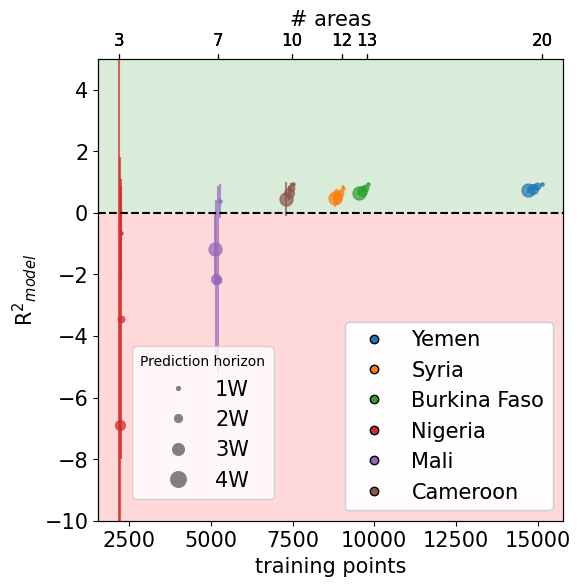

In [8]:
fig, axs = plt.subplots(figsize = (6, 6))

for i, country in enumerate(COUNTRIES):
    # Load training shapes.
    training_shape = pd.read_csv(f"{PROJECT_ROOT}/{country}/standard/out_test/training_shapes.csv", header = [0,1], index_col = 0)
    training_shape = training_shape.xs("training points", axis = 1, level = 1, drop_level = False)

    # Load mse loss based on prediction horizons.
    r2_results = pd.read_csv(f"{PROJECT_ROOT}/{country}/standard/out_test/r2_results.csv", index_col = 0, header = [0, 1, 2])
    r2_results = r2_results.droplevel(level = 0, axis = 1)

    results = r2_results.stack(["Split"])

    # For each split get difference between 'r2_naive' and 'r2_model'.
    results["diff"] =  results["r2_model"]
    results = results.unstack().reorder_levels(["Split", "Type"], axis = 1).xs("diff", axis = 1, level = 1, drop_level = False)
    # Concatenate loss and training shape information.
    results = pd.concat([results, training_shape], axis = 1).sort_index(axis = 1)
    # Take the mean across all the splits.
    results_mean = results.groupby(axis = 1, level = 1).mean()
    results_std = results.groupby(axis = 1, level = 1).std()
    # Select some prediction horizon for visualiztion.
    results_mean = results_mean.loc[[7, 14, 21, 28]]
    results_std = results_std.loc[[7, 14, 21, 28]]
    
    # Provinces.
    with open(f"{PROJECT_ROOT}/{country}/standard/provinces_considered", "rb") as fp:
        provinces = pickle.load(fp)
    n_provinces.append((len(provinces[country]), training_shape.mean().mean()))

    for j in range(len(results_mean)):
        axs.errorbar(results_mean.iloc[j]["training points"], results_mean.iloc[j]["diff"],
                     yerr = results_std.iloc[j]["diff"], marker = "o", linestyle = "none", 
                     color = sns.color_palette("tab10")[i], markersize = results_mean.index[j]/3, 
                     alpha = 0.7)

# Add 0 line.
axs.axhline(y = 0, color = "black", linestyle = "--")

ax2 = axs.twiny()
ax2.plot([x[1] for x in n_provinces], np.ones(len(n_provinces)), alpha = 0) # Create a dummy plot
xticks = ax2.get_xticks()
ax2.set_xticks([x[1] for x in n_provinces])
ax2.set_xticklabels([str(x[0]) for x in n_provinces], fontdict = {'fontsize': 12})
ax2.set_xlabel("# areas")
 
# Legend.
h = [plt.plot([],[], color = sns.color_palette("tab10")[i], marker = "o", ls = "", markeredgewidth = 1, 
              markeredgecolor = "black")[0] for i, country in enumerate(COUNTRIES)]
h = plt.legend(handles = h, labels = COUNTRIES, loc = "lower right")

h1 = [plt.plot([],[], color = "gray", marker = "o", ms = i, ls = "")[0] for i in results_mean.index.values/2.5]
axs.legend(handles = h1, labels = ["1W", "2W", "3W", "4W"], loc = "upper right", bbox_to_anchor = (0.4,0.4), 
           title = "Prediction horizon")

plt.gca().add_artist(h)

axs.set_xlabel("training points")
axs.set_ylabel("R$^2$$_{model}$")

a = (axs.get_xlim()[0], axs.get_xlim()[1])
b = (axs.get_ylim()[0], 50)

axs.fill_between(np.arange(a[0], a[1]), 0, b[1], facecolor = "green", alpha = 0.15)
axs.fill_between(np.arange(a[0], a[1]), 0, b[0], facecolor = "red", alpha = 0.15)

axs.set_xlim(a)
axs.set_ylim((-10, 5))

fig.savefig(f"./IMAGES/{ANALYSIS_NAME}/all_countries_3.png" , bbox_inches = "tight", dpi = 300)